# pd.DataFrame改进版

源代码：

In [54]:
import pandas as pd
import numpy as np


class DataFrameInfo(pd.DataFrame):
    '''
    定义一个类，继承pandas.DataFrame，方便查看数据和其他EDA定制化数据查看需求。
    '''

    def preview(self):
        '''
        用于数据预览，查看数据集的各种数据属性。


        returns:

        total: 数量,
        na: 空值,
        naPercent: 空值所占该列比例,
        dtype: 该列的数据类型(dtype),
        max: 该列最大值,
        75%: 75%分位数,
        median: 中位数,
        25%: 25%分位数,
        min:该列最小值,
        mean: 均值,
        mode: 众数,
        variation: 异众比率,
        std: 标准差,
        skew: 偏度系数,
        kurt: 峰度系数,
        sampleVals: 随机返回该列两个值
        '''
        ind = self.index
        col = self.columns
        ind_len = self.shape[0]
        col_len = len(col)
        df = pd.DataFrame(columns=['total', 'na', 'naPercent', 'dtype', 'max', '75%', 'median',
                                   '25%', 'min', 'mean', 'mode', 'variation', 'std', 'skew', 'kurt', 'sampleVals'])

        pointer = 0
        for i in col:
            sampleVals = ' || '.join([str(self[i][j]) for j in np.random.randint(ind_len, size=2)])
            if sum(self.iloc[:, pointer].apply(lambda s: isinstance(s, (float, int)))) == \
                    len(self.iloc[:, pointer]):
                value = {'total': ind_len,
                         'na': self[i].isnull().sum(),
                         'naPercent': self[i].isnull().sum() / ind_len,
                         'dtype': self[i].dtype,
                         'max': self[i].max(),
                         '75%': self[i].quantile(0.75),
                         'median': self[i].median(),
                         '25%': self[i].quantile(0.25),
                         'min': self[i].min(),
                         'mean': self[i].mean(),
                         'mode': self[i].value_counts(ascending=False).index[0],
                         'variation': self[i].value_counts(ascending=False).values[1:].sum() / ind_len,
                         'std': self[i].std(),
                         'skew': self[i].skew(),
                         'kurt': self[i].kurt(),
                         'sampleVals': sampleVals
                         }
            else:
                value = {'total': ind_len,
                         'na': self[i].isnull().sum(),
                         'naPercent': self[i].isnull().sum() / ind_len,
                         'dtype': self[i].dtype,
                         'max': np.nan,
                         '75%': np.nan,
                         'median': np.nan,
                         '25%': np.nan,
                         'min': np.nan,
                         'mean': np.nan,
                         'mode': self[i].value_counts(ascending=False).index[0],
                         'variation': self[i].value_counts(ascending=False).values[1:].sum() / ind_len,
                         'std': np.nan,
                         'skew': np.nan,
                         'kurt': np.nan,
                         'sampleVals': sampleVals
                         }
            df.loc[i] = pd.Series(value, name=i)
            pointer += 1

        return df

    def _countNullStringAndGetType(self, col):
        '''
        判断传入列的每个值是否为空字符串，并获取该值数据类型。

        params:
        col: pandas Series

        returns：

        一个列表，包含该列的空字符串数目、以及一个该列所有值的数据类型的set集合。
        '''
        count = 0
        types = set()
        for j in col:
            if isinstance(j, str) and j.strip() == "":
                count += 1
            types.add(type(j))

        return [count, types]

    def abnormal(self):
        '''
        查看数据集的异常值情况。


        returns：

        na: 该列的空值数目,
        nullStrings: 该列空字符串数目,
        valueTypes：该列所有数值的数据类型set集合
        '''

        df = pd.DataFrame(columns=['na', 'nullStrings', 'valueTypes'])

        for i in self.columns:
            df.loc[i] = pd.Series({
                'na': sum(self[i].isna()),
                'nullStrings': self._countNullStringAndGetType(self[i])[0],
                'valueTypes': self._countNullStringAndGetType(self[i])[1]
            }, name=i)


        return df



dfi = DataFrameInfo

# 导入所需的包和模块

In [55]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

%matplotlib inline

In [56]:
train_set = pd.read_csv("/content/drive/My Drive/竞赛/员工预测赛/Employee_Satisfaction/训练集.csv")
test_set = pd.read_csv("/content/drive/My Drive/竞赛/员工预测赛/Employee_Satisfaction/测试集.csv")

In [57]:
# col = ['id','上次评分','项目数量','平均月工时','工龄','工伤','福利等级','五年内有升职','部门','工资水平','满意度']
# name = {i:j for i,j in zip(train_set.columns,col)}
# train = train_set.rename(columns=name)
# test= test_set.rename(columns=name)

train = train_set.copy()
test = test_set.copy()

In [58]:
train

,id,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,division,salary,satisfaction_level
0,13697,0.99,3,161.39,2,0,a,0,accounting,medium,0.681
1,1142,1.00,5,226.22,6,0,b,0,marketing,low,0.876
2,7954,0.91,5,199.45,2,0,e,0,sales,medium,0.955
3,2225,0.51,3,235.14,3,0,c,0,sales,low,0.817
4,9753,0.89,3,219.91,2,0,a,0,technical,low,0.920
...,...,...,...,...,...,...,...,...,...,...,...
11994,11971,0.89,4,150.45,3,0,e,0,accounting,high,0.849
11995,14966,0.81,5,221.28,5,0,b,0,sales,low,0.836
11996,7491,0.60,4,136.36,4,1,c,0,sales,medium,0.915
11997,12680,0.84,6,268.54,4,0,b,0,IT,low,0.099


# 查看数据集信息

In [59]:
train = dfi(train)
train.preview()

,total,na,naPercent,dtype,max,75%,median,25%,min,mean,mode,variation,std,skew,kurt,sampleVals
id,11999,0,0.0,int64,14998,11248.500,7532.000,3750.500,0,7507.265855,2047,0.999917,4328.395859,-0.004826,-1.198865,13954 || 6984
last_evaluation,11999,0,0.0,float64,1,0.870,0.720,0.560,0.35,0.715750,0.54,0.975998,0.170733,-0.022749,-1.229689,0.56 || 0.54
number_project,11999,0,0.0,int64,7,5.000,4.000,3.000,2,3.795816,4,0.710226,1.229931,0.341848,-0.490997,5 || 4
average_monthly_hours,11999,0,0.0,float64,313.11,246.020,201.020,157.135,95.1,202.201511,236.66,0.999417,49.887899,0.055967,-1.137477,148.1 || 136.98
time_spend_company,11999,0,0.0,int64,10,4.000,3.000,3.000,2,3.500875,3,0.568547,1.464127,1.868202,4.839692,6 || 2
Work_accident,11999,0,0.0,int64,1,0.000,0.000,0.000,0,0.145179,0,0.145179,0.352296,2.014674,2.059253,0 || 0
package,11999,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,c,0.741395,NaN,NaN,NaN,a || e
promotion_last_5years,11999,0,0.0,int64,1,0.000,0.000,0.000,0,0.020585,0,0.020585,0.141996,6.753619,43.618639,0 || 0
division,11999,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,sales,0.724727,NaN,NaN,NaN,sales || IT
salary,11999,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,low,0.509459,NaN,NaN,NaN,low || medium


In [60]:
test = dfi(test)
test.preview()

,total,na,naPercent,dtype,max,75%,median,25%,min,mean,mode,variation,std,skew,kurt,sampleVals
id,3000,0,0.0,int64,14996,11246.2500,7382.000,3744.000,10,7465.939333,13438,0.999667,4336.888431,0.019289,-1.203971,6753 || 9015
last_evaluation,3000,0,0.0,float64,1,0.8700,0.720,0.560,0.35,0.717717,0.5,0.973000,0.172901,-0.043927,-1.260734,0.91 || 0.45
number_project,3000,0,0.0,int64,7,5.0000,4.000,3.000,2,3.832000,4,0.704000,1.242963,0.320652,-0.512083,5 || 4
average_monthly_hours,3000,0,0.0,float64,311.94,245.4675,200.875,156.815,96.93,201.458893,192.85,0.998667,50.224990,0.039802,-1.125264,139.7 || 137.89
time_spend_company,3000,0,0.0,int64,10,4.0000,3.000,3.000,2,3.487667,3,0.578000,1.444256,1.791334,4.493163,3 || 3
Work_accident,3000,0,0.0,int64,1,0.0000,0.000,0.000,0,0.142333,0,0.142333,0.349450,2.048392,2.197375,0 || 0
package,3000,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,c,0.733000,NaN,NaN,NaN,b || a
promotion_last_5years,3000,0,0.0,int64,1,0.0000,0.000,0.000,0,0.024000,0,0.024000,0.153075,6.223342,36.754485,0 || 0
division,3000,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,sales,0.721000,NaN,NaN,NaN,technical || technical
salary,3000,0,0.0,object,NaN,NaN,NaN,NaN,NaN,NaN,low,0.523333,NaN,NaN,NaN,low || medium


### 查看各个分类特征列的取值频率

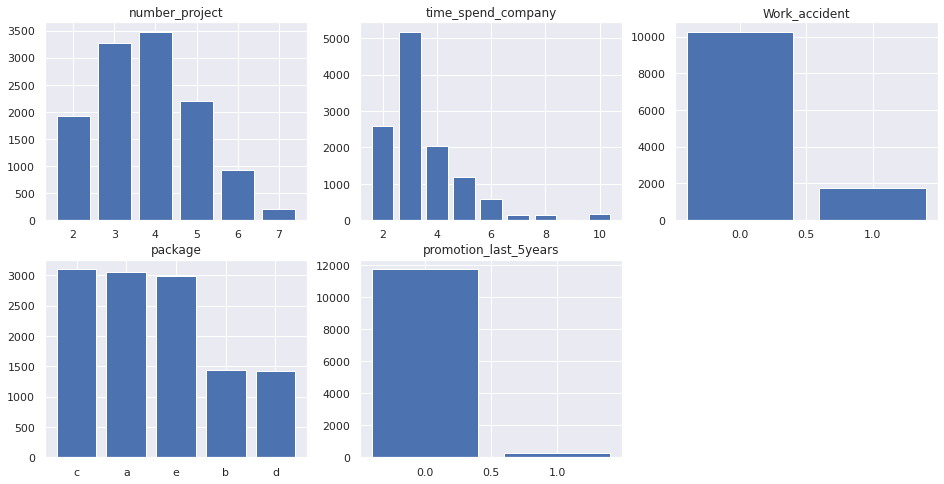

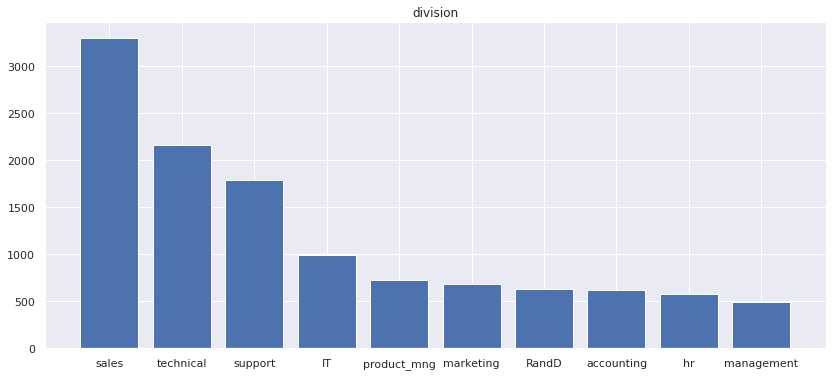

In [61]:
def valuecount_plot(df):
    sns.set()
    cols = ['number_project','time_spend_company', 'Work_accident', 'package', 'promotion_last_5years']
    plt.figure(figsize=(16,8))
    pointer = 0
    for i in cols:
        plt.subplot(231+pointer)
        plt.bar(x= df[i].value_counts().index, height= df[i].value_counts().values)
        plt.title(i)
        print()
        pointer += 1
        
    plt.figure(figsize=(14,6))
    plt.bar(x= df['division'].value_counts().index, height= df['division'].value_counts().values)
    plt.title('division')
        
valuecount_plot(train)

## 查看各列之间的相关性

### 线性相关

In [62]:
corr = {'train_corr': train.corr(), 'test_corr': test.corr()}

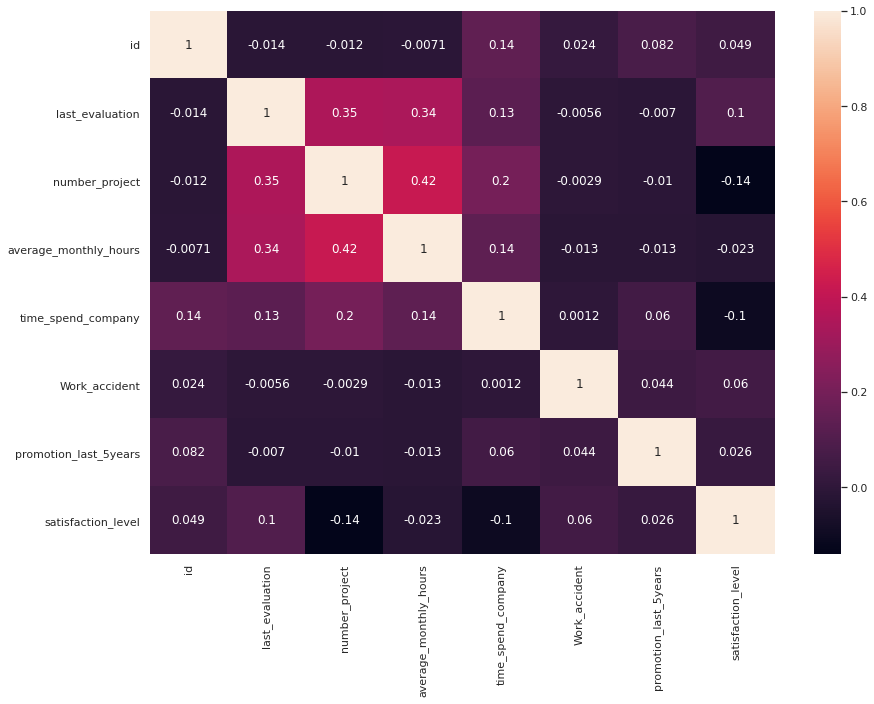

In [63]:
sns.set()
plt.figure(figsize=(14,10))
sns.heatmap(corr['train_corr'], annot=True)
print()

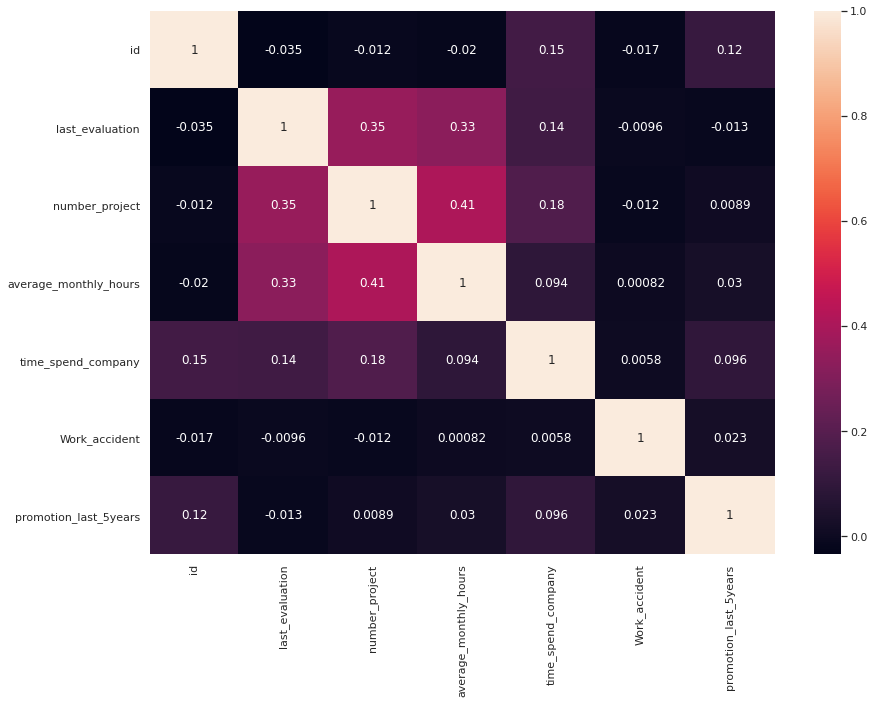

In [64]:
sns.set()
plt.figure(figsize=(14,10))
sns.heatmap(corr['test_corr'], annot=True)
print()

### 非线性相关

In [65]:
corr = {'train_corr': train.corr('spearman'), 'test_corr': test.corr('spearman')}

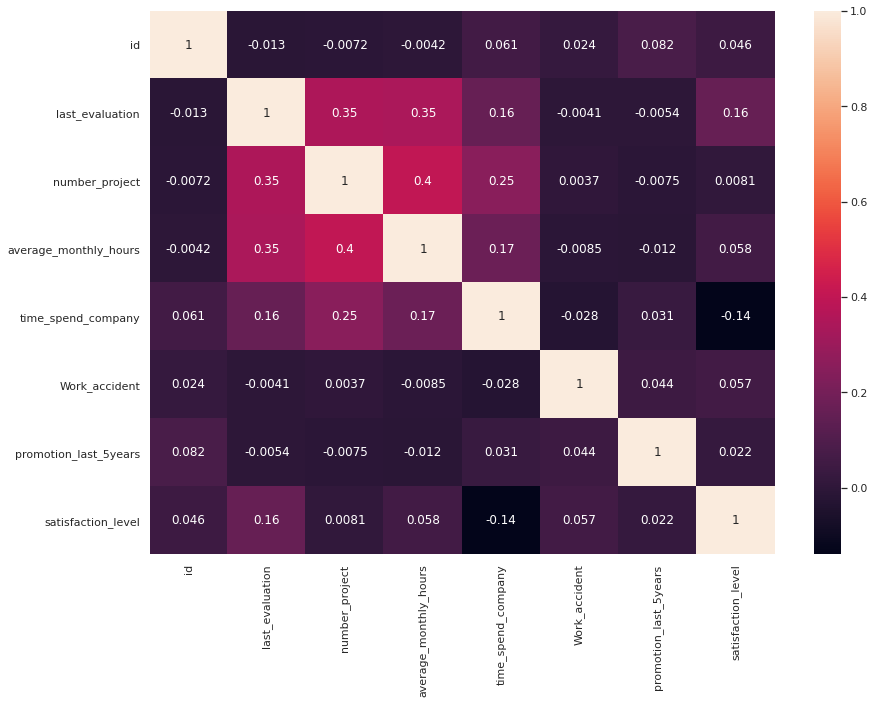

In [66]:
sns.set()
plt.figure(figsize=(14,10))
sns.heatmap(corr['train_corr'], annot=True)
print()

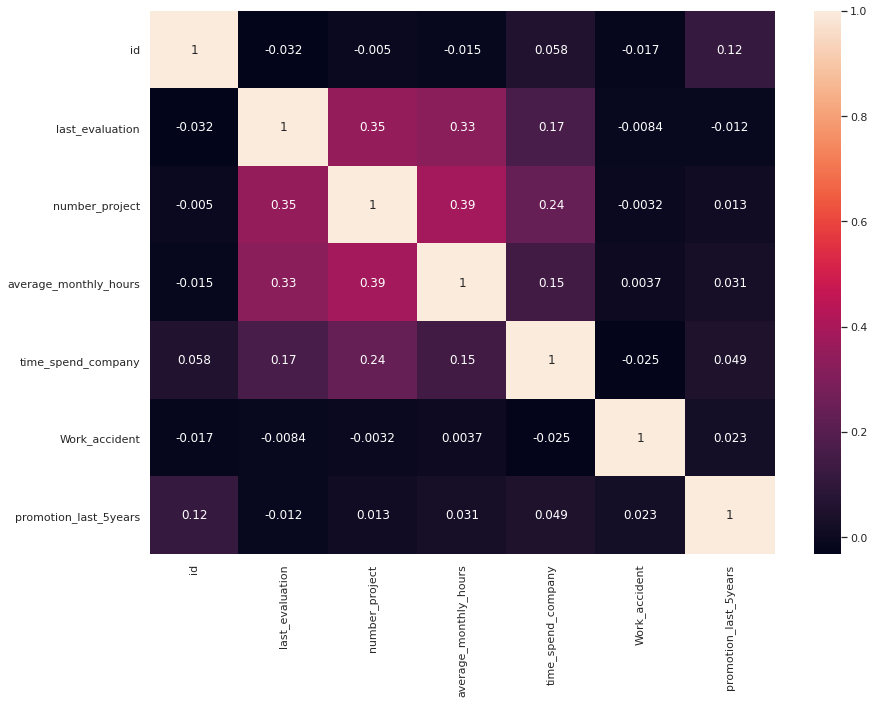

In [67]:
sns.set()
plt.figure(figsize=(14,10))
sns.heatmap(corr['test_corr'], annot=True)
print()

## 重复值、缺失值、异常值

### 重复值

In [68]:
print(f"training set duplicated rows amount : {sum(train.duplicated())}")
print(f"testing set duplicated rows amount : {sum(test.duplicated())}")

training set duplicated rows amount : 0
testing set duplicated rows amount : 0


### 缺失值

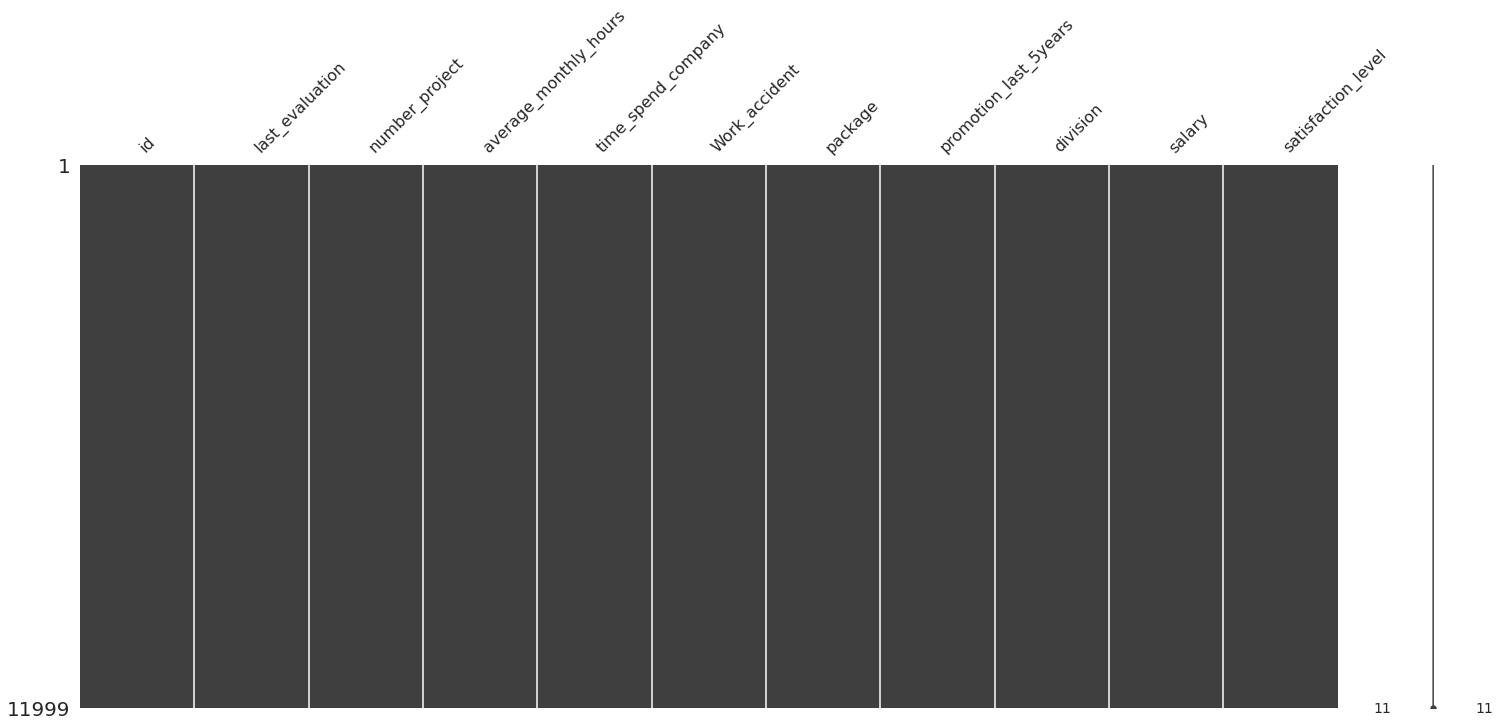

In [69]:
# train数据集没有缺失值
msno.matrix(train)
plt.show()

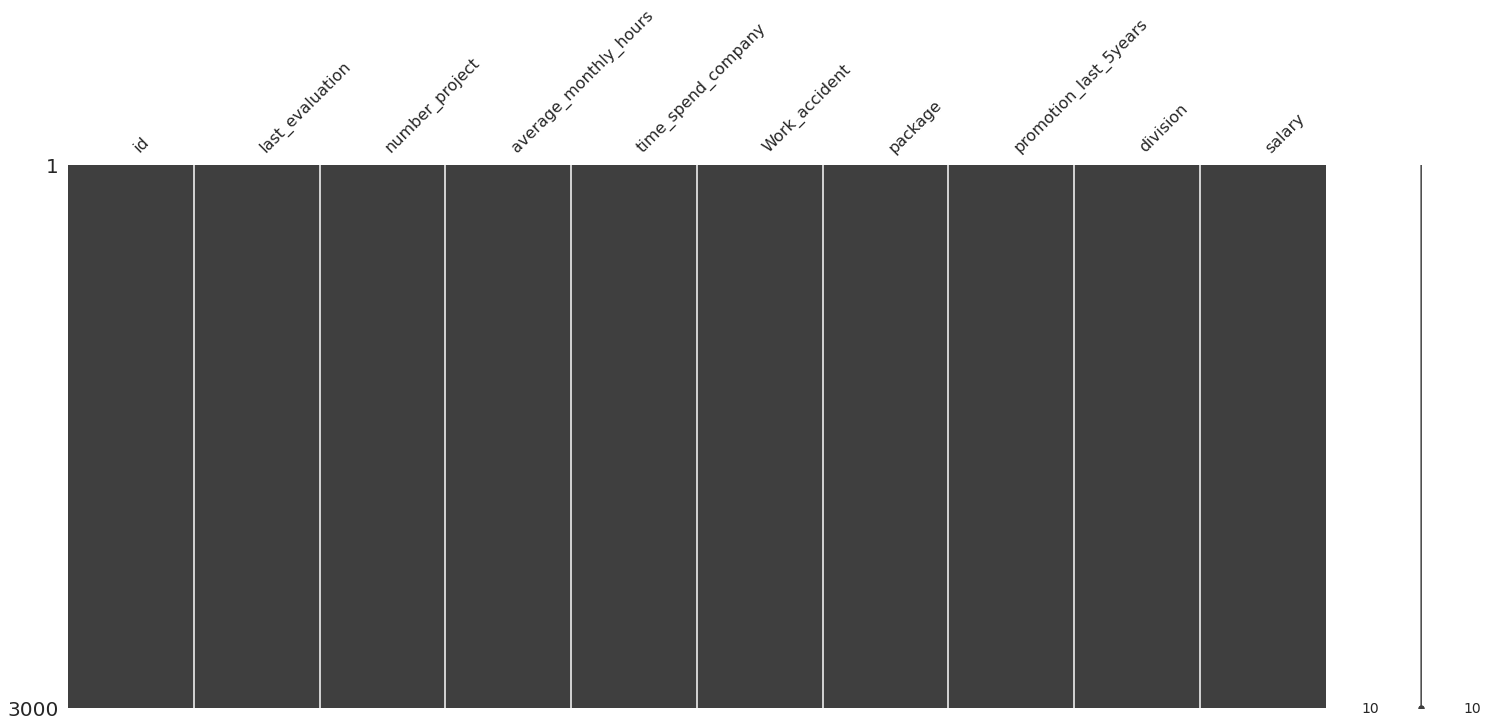

In [70]:
# test数据集没有缺失值
msno.matrix(test)
plt.show()

可以看到无论是train，还是test数据集，都没有缺失值。

### 异常值

In [71]:
train.abnormal()

,na,nullStrings,valueTypes
id,0,0,{<class 'int'>}
last_evaluation,0,0,{<class 'float'>}
number_project,0,0,{<class 'int'>}
average_monthly_hours,0,0,{<class 'float'>}
time_spend_company,0,0,{<class 'int'>}
Work_accident,0,0,{<class 'int'>}
package,0,0,{<class 'str'>}
promotion_last_5years,0,0,{<class 'int'>}
division,0,0,{<class 'str'>}
salary,0,0,{<class 'str'>}


In [72]:
test.abnormal()

,na,nullStrings,valueTypes
id,0,0,{<class 'int'>}
last_evaluation,0,0,{<class 'float'>}
number_project,0,0,{<class 'int'>}
average_monthly_hours,0,0,{<class 'float'>}
time_spend_company,0,0,{<class 'int'>}
Work_accident,0,0,{<class 'int'>}
package,0,0,{<class 'str'>}
promotion_last_5years,0,0,{<class 'int'>}
division,0,0,{<class 'str'>}
salary,0,0,{<class 'str'>}


各列都无异常值

## 查看数据分布

In [73]:
train.columns

Index(['id', 'last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'division', 'salary', 'satisfaction_level'],
      dtype='object')

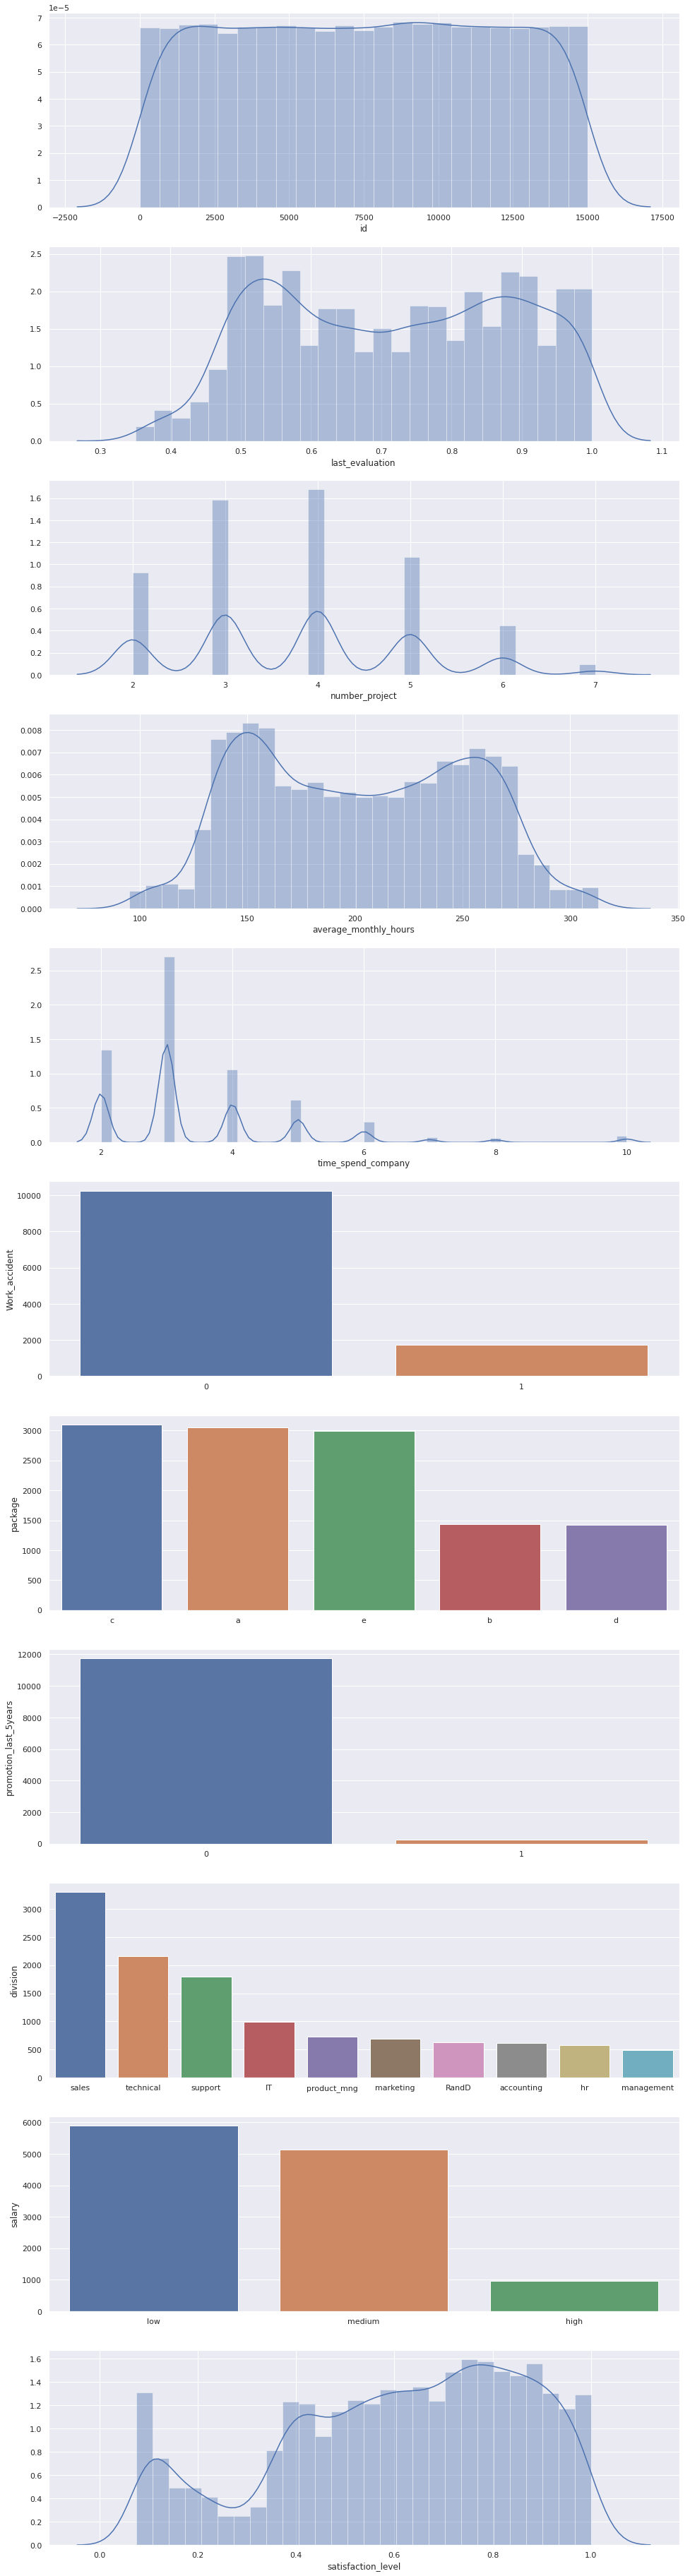

In [74]:
l = len(train.columns)
plt.figure(figsize=(16,6*l))
for i in range(l):
    plt.subplot(l,1,i+1)
    if train.iloc[:,i].dtype != 'object' and train.iloc[:,i].name not in ['Work_accident','promotion_last_5years']:
        sns.distplot(train.iloc[:,i])
    else:
        sns.barplot(x = train.iloc[:,i].value_counts().index,y=train.iloc[:,i].value_counts())

## 数据分布探索总结


- 特征分类
  - id列为无意义列，可以删除
  - 上次评分、平均月工时、满意度 为连续型数据
  - 工龄、项目数量为离散型数据
  - 工伤、五年内有升职 为0-1二值型数据，
  - 部门为文本型数据，考虑进行独热编码
  - 福利等级、工资水平为定序数据，需要进行顺序编码
- 量纲
  - 工龄单位是年，样本取值在2-10之间
  - 项目数量是个，整型数据，样本取值在2-7之间
  - 平均月工时是小时，浮点型，样本取值为95.1 - 313.11
  - 上次评分是分数，样本取值为0-1之间
- 特征相关性
  - 训练集、测试集各自列与列之间没有明显线性或非线性相关性
- 缺失值、异常值、重复值
  - 无
- 数据分布
 - 过去5年基本上没有人升过职，升职人数占train数据集总人数仅2%，考虑对升职记录进行过采样
 - 工伤比例大概在15%
 


# 数据预处理

In [75]:
# id列没有用处，直接删除
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [76]:
train

,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,division,salary,satisfaction_level
0,0.99,3,161.39,2,0,a,0,accounting,medium,0.681
1,1.00,5,226.22,6,0,b,0,marketing,low,0.876
2,0.91,5,199.45,2,0,e,0,sales,medium,0.955
3,0.51,3,235.14,3,0,c,0,sales,low,0.817
4,0.89,3,219.91,2,0,a,0,technical,low,0.920
...,...,...,...,...,...,...,...,...,...,...
11994,0.89,4,150.45,3,0,e,0,accounting,high,0.849
11995,0.81,5,221.28,5,0,b,0,sales,low,0.836
11996,0.60,4,136.36,4,1,c,0,sales,medium,0.915
11997,0.84,6,268.54,4,0,b,0,IT,low,0.099


# EDA

## 各列相关性探索分析

In [77]:
train.groupby('promotion_last_5years')['satisfaction_level'].describe()

,count,mean,std,min,25%,50%,75%,max
promotion_last_5years,,,,,,,,
0,11752.0,0.612923,0.249725,0.076,0.437,0.645,0.8170,1.0
1,247.0,0.658081,0.209522,0.110,0.527,0.688,0.8145,1.0


In [78]:
train.groupby('Work_accident')['satisfaction_level'].describe()

,count,mean,std,min,25%,50%,75%,max
Work_accident,,,,,,,,
0,10257.0,0.607733,0.251446,0.076,0.43100,0.639,0.814,1.0
1,1742.0,0.649887,0.231159,0.085,0.51525,0.674,0.832,1.0


In [79]:
train.groupby('time_spend_company')['satisfaction_level'].describe()

,count,mean,std,min,25%,50%,75%,max
time_spend_company,,,,,,,,
2,2579.0,0.695919,0.184761,0.086,0.56550,0.703,0.845,1.000
3,5177.0,0.629892,0.208063,0.113,0.44000,0.626,0.805,1.000
4,2033.0,0.469199,0.318590,0.076,0.11000,0.513,0.750,1.000
5,1182.0,0.605276,0.287202,0.081,0.30875,0.741,0.837,1.000
6,580.0,0.603957,0.272936,0.112,0.33725,0.692,0.822,0.990
7,142.0,0.615380,0.248317,0.145,0.48225,0.643,0.828,1.000
8,129.0,0.662922,0.216040,0.149,0.54300,0.685,0.834,0.994
10,177.0,0.663153,0.219132,0.130,0.53500,0.652,0.848,0.997


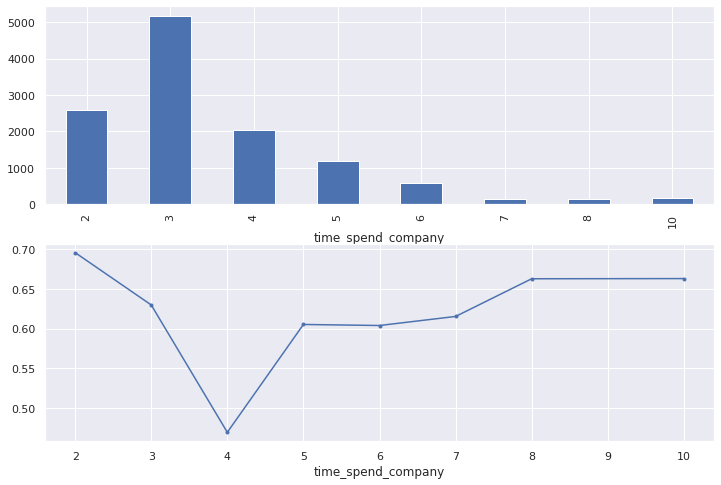

In [80]:
sns.set()
plt.figure(figsize=(12,8))
plt.subplot(211)
train.groupby('time_spend_company')['satisfaction_level'].describe()['count'].plot(kind='bar')
plt.subplot(212)
train.groupby('time_spend_company')['satisfaction_level'].describe()['mean'].plot(kind='line',marker='.')
plt.show()

# 特征工程

## 思路
- division为文本型数据，考虑进行独热编码 one-hot encoder
- package、salary为定序数据，需要进行顺序编码 ordinal encoder
- Work_accident、promotion_last_5years：
 - 考虑对频数较低的组进行过采样（需谨慎，在此数据集上建议采用简单随机过采样）
    - 大多数过采样方法会使变量的方差表面上比实际上更小，欠采样会让独立变量的方差看起来比其实际的方差更高。另外，因为通过过采样增加少数类样本的数据量很难增加数据所包含的信息，容易造成模型过拟合。
    - 应用在此数据集中，容易对categorical型数据进行改动，使其失去categorical特征（如使用SMOTE或者其他基于KNN算法的过采样算法时，其会对K个近邻样本参考，并计算生成新的采样样本，这是categorical特征可能会出现小数，变成连续型特征。），不建议采用。 
 - 或者将promotion_last_5years为1的删除
 - 或者使用随机森林查看一下重要程度



## 划分训练集和测试集

### 划分自变量和因变量

In [81]:
x = train.iloc[:,:-1]
y = train.iloc[:, -1]

### 划分训练、测试集

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [83]:
x_train['promotion_last_5years'].value_counts()

0    8223
1     176
Name: promotion_last_5years, dtype: int64

## Encoding transform

In [84]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

oe = OrdinalEncoder()
x_train[['package', 'salary']] = oe.fit_transform(x_train[['package', 'salary']])
oh = OneHotEncoder()
result = oh.fit_transform(x_train['division'].values.reshape(-1,1))

result = pd.DataFrame(result.toarray(), columns=x_train['division'].unique(), index=x_train.index)
x_train_new = pd.concat([x_train, result], axis=1)
x_train_new.drop(columns='division',inplace=True)
x_train_new


,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,salary,sales,hr,RandD,support,management,product_mng,IT,technical,accounting,marketing
3437,0.56,3,190.18,2,0,2.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8791,0.59,3,273.49,2,1,4.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6664,0.94,3,178.77,4,0,2.0,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10174,0.55,5,257.84,3,0,2.0,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8904,0.45,2,146.77,3,0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11609,0.69,2,166.13,2,0,4.0,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11672,0.76,4,247.42,3,0,2.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8687,0.92,3,138.57,10,0,2.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7941,0.48,2,128.35,3,0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [85]:
x_test[['package', 'salary']] = oe.transform(x_test[['package', 'salary']])
result = oh.transform(x_test['division'].values.reshape(-1,1))

result = pd.DataFrame(result.toarray(), columns=x_test['division'].unique(), index=x_test.index)
x_test_new = pd.concat([x_test, result], axis=1)
x_test_new.drop(columns='division',inplace=True)
x_test_new

,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,salary,technical,hr,marketing,sales,support,product_mng,IT,RandD,accounting,management
10434,0.73,4,196.55,5,1,2.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1769,0.61,4,240.22,3,0,1.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7983,0.99,5,144.89,3,0,0.0,0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6872,0.55,3,247.06,3,0,4.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9461,0.98,4,248.10,5,0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,0.68,5,156.47,2,0,4.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7544,0.82,4,218.35,5,0,3.0,0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8380,0.96,6,282.58,4,0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8981,0.91,6,301.55,4,0,3.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [86]:
x_train_new.columns == x_test_new.columns

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False, False, False,  True,  True, False,  True, False])

### 使训练集和测试集的列对齐

In [87]:
x_train_new.columns

Index(['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'salary', 'sales', 'hr', 'RandD', 'support',
       'management', 'product_mng', 'IT', 'technical', 'accounting',
       'marketing'],
      dtype='object')

In [88]:
x_test_new = x_test_new[['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'salary', 'technical', 'support', 'sales',
       'accounting', 'marketing', 'IT', 'hr', 'RandD', 'product_mng',
       'management']]

In [89]:
x_train_new.columns == x_test_new.columns

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False])

## over_resample

### 对promotion_last_5years值为1的样本进行随机过采样（插值）

In [90]:
x_train_new2 = x_train_new.copy()
x_train_new2['satisfaction_level'] = y_train

ros = RandomOverSampler()
x_res, y_res = ros.fit_resample(x_train_new2.loc[:, x_train_new2.columns != 'promotion_last_5years'], 
                 x_train_new2.loc[:, x_train_new2.columns == 'promotion_last_5years'])

In [91]:
x_train_new2.columns

Index(['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'salary', 'sales', 'hr', 'RandD', 'support',
       'management', 'product_mng', 'IT', 'technical', 'accounting',
       'marketing', 'satisfaction_level'],
      dtype='object')

In [92]:
x_res = pd.DataFrame(x_res, columns=['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package', 'salary', 'IT', 'sales', 'marketing', 'hr',
       'technical', 'RandD', 'product_mng', 'support', 'management',
       'accounting', 'satisfaction_level'])
x_res['promotion_last_5years'] = y_res
x_res = x_res[['last_evaluation', 'number_project', 'average_monthly_hours',
       'time_spend_company', 'Work_accident', 'package',
       'promotion_last_5years', 'salary', 'technical', 'support', 'sales',
       'accounting', 'marketing', 'IT', 'hr', 'RandD', 'product_mng',
       'management', 'satisfaction_level']]
x_res

,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,package,promotion_last_5years,salary,technical,support,sales,accounting,marketing,IT,hr,RandD,product_mng,management,satisfaction_level
0,0.56,3.0,190.18,2.0,0.0,2.0,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.761
1,0.59,3.0,273.49,2.0,1.0,4.0,0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.936
2,0.94,3.0,178.77,4.0,0.0,2.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.151
3,0.55,5.0,257.84,3.0,0.0,2.0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.563
4,0.45,2.0,146.77,3.0,0.0,3.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16441,0.78,5.0,258.47,3.0,0.0,2.0,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.976
16442,0.94,3.0,193.91,10.0,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221
16443,0.76,3.0,164.76,3.0,0.0,4.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.723
16444,0.83,4.0,183.08,2.0,1.0,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.801


In [93]:
from collections import Counter
Counter(x_res['promotion_last_5years'])

Counter({0: 8223, 1: 8223})

In [94]:
x_res_train = x_res.iloc[:,:-1]
y_res_train = x_res.iloc[:,-1] 

In [95]:
y_res_train

0        0.761
1        0.936
2        0.151
3        0.563
4        0.429
         ...  
16441    0.976
16442    0.221
16443    0.723
16444    0.801
16445    0.818
Name: satisfaction_level, Length: 16446, dtype: float64

## 特征选择

### 使用互信息筛选特征

In [96]:
skb = SelectKBest(mutual_info_regression).fit(x_res_train, y_res_train)

In [97]:
np.round(skb.scores_, 2)

array([1.72, 0.7 , 2.64, 0.77, 0.2 , 0.61, 0.45, 0.36, 0.21, 0.22, 0.1 ,
       0.08, 0.05, 0.02, 0.07, 0.13, 0.  , 0.07])

In [98]:
x_res_train_new = x_res_train[x_res_train.columns[skb.scores_ > 0.05]]
x_res_train_new.shape

(16446, 16)

In [99]:
x_test_new2 = x_test_new[x_test_new.columns[skb.scores_ > 0.05]]
x_test_new2.shape

(3600, 16)

### 使用随机森林从互信息筛选后结果中选择满足条件的特征


In [100]:
rfr1 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
selector = SelectFromModel(rfr1).fit(x_res_train_new, y_res_train)
x_res_train_new2 = selector.transform(x_res_train_new)

In [101]:
x_test_new2 = selector.transform(x_test_new2)

In [102]:
x_res_train_new2.shape

(16446, 4)

In [103]:
x_test_new2.shape

(3600, 4)

### 验证选择结果

随机森林

In [104]:
rfr2 = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rfr2.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, rfr2.predict(x_test_new2))

0.03564872345553105

In [105]:
rfr_gs = RandomForestRegressor(oob_score=True, n_jobs=-1)
params = {
    'n_estimators': range(100, 1000, 100)

}

gscv = GridSearchCV(rfr_gs, params)
gscv.fit(x_res_train_new2, y_res_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [106]:
gscv.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=700, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [107]:
mean_squared_error(y_test, gscv.predict(x_test_new2))

0.03539670563796632

线性回归

In [108]:
lin_reg = LinearRegression()
lin_reg.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, lin_reg.predict(x_test_new2))

0.059759260213393256

lasso & ridge

在选择岭回归和Lasso时候，标准化是必须的。原因是正则化是有偏估计，会对权重进行惩罚。在量纲不同的情况，正则化会带来更大的偏差


In [109]:
lasso = Pipeline(
    [
     ('standard_df', StandardScaler()),
     ('lasso_cv',  LassoCV(cv=5)) # cv默认为5折交叉验证
    ]
)

lasso.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, lasso.predict(x_test_new2))

0.05976035157043868

ridge

In [110]:
ridge = Pipeline(
    [
     ('standard_df', StandardScaler()),
     ('ridge_cv',  RidgeCV(cv=5))   # 不指定cv则默认使用留一法交叉验证
    ]
)

ridge.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, ridge.predict(x_test_new2))

0.05976008115005124

多项式回归

In [111]:
# 2次幂
poly_reg = Pipeline(
    [
     ('poly', PolynomialFeatures(degree=2)),
     ('standard_df', StandardScaler()),
     ('lin_reg',LinearRegression())
    ]
    )

poly_reg.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, poly_reg.predict(x_test_new2))

0.04203280252498155

In [112]:
# 3次幂
poly_reg = Pipeline(
    [
     ('poly', PolynomialFeatures(degree=3)),
     ('standard_df', StandardScaler()),
     ('lin_reg',LinearRegression())
    ]
    )

poly_reg.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, poly_reg.predict(x_test_new2))

0.04175075473651567

交叉验证

In [113]:
# 注意这里使用的是负均方差函数
cross_score = cross_val_score(RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True),
                x_res_train_new2, y_res_train, cv=5, scoring='neg_mean_squared_error')
print(f"cross_score = {-1 * cross_score}")
print(f"cross_score_mean = {-1 * cross_score.mean()}")

cross_score = [3.72422608e-02 3.70730657e-02 2.00548172e-02 8.51886085e-12
 6.25288904e-12]
cross_score_mean = 0.01887402874347478


xgboost

In [114]:
xgb_reg = XGBRegressor(n_estimators=100,n_jobs=-1, verbosity=0)
xgb_reg.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, xgb_reg.predict(x_test_new2))

0.037098932325068334

In [115]:
pxgb1 = {'learning_rate':[0.01,0.04,0.07,0.10],
        'min_child_weight':[1,0.9,0.8,0.7,0.5]}

xgb_gs = XGBRegressor(n_estimators=100,n_jobs=-1, verbosity=0)
params = {'learning_rate':[0.01,0.04,0.07,0.10],
        'min_child_weight':[1,0.9,0.8,0.7,0.5]}

gscv_xgb = GridSearchCV(xgb_gs, params)
gscv_xgb.fit(x_res_train_new2, y_res_train)

mean_squared_error(y_test, gscv_xgb.predict(x_test_new2))

0.037098932325068334

In [116]:
gscv_xgb.best_params_

{'learning_rate': 0.1, 'min_child_weight': 1}

In [117]:
# 注意这里使用的是负均方差函数
cross_score = cross_val_score(XGBRegressor(n_estimators=100,n_jobs=-1, verbosity=0),
                x_res_train_new2, y_res_train, cv=5, scoring='neg_mean_squared_error')
print(f"cross_score = {-1 * cross_score}")
print(f"cross_score_mean = {-1 * cross_score.mean()}")

cross_score = [0.03807654 0.0371474  0.02589302 0.0166215  0.01489004]
cross_score_mean = 0.026525702768026366


# 特征选择效果还行，试试全量训练



随机森林

In [122]:
rfr_all = RandomForestRegressor(n_estimators=700, n_jobs=-1, oob_score=True)
rfr_all.fit(x_res_train, y_res_train)

mean_squared_error(y_test, rfr_all.predict(x_test_new))

0.03340204020324441

In [ ]:
rfr_all_gs = RandomForestRegressor(oob_score=True, n_jobs=-1, bootstrap=True, random_state=0)
params = {
    'n_estimators': range(100, 1000, 100),
    'max_samples': range(500, 5000, 500),
    'max_features': range(3, 19, 1)
}
1
rfr_all_gscv = GridSearchCV(rfr_gs, params)
rfr_all_gscv.fit(x_res_train, y_res_train)
mean_squared_error(y_test, rfr_all_gscv.predict(x_test_new))

xgboost


In [ ]:
xgb_reg2 = XGBRegressor(n_estimators=100,n_jobs=-1, verbosity=0)
xgb_reg2.fit(x_res_train, y_res_train)

mean_squared_error(y_test, xgb_reg2.predict(x_test_new))

linearSVC

In [ ]:
lin_svr = Pipeline(
    [
     ('standard_df', StandardScaler()),
     ('linSVR', LinearSVR())
    ]
)

lin_svr.fit(x_res_train, y_res_train)

mean_squared_error(y_test, lin_svr.predict(x_test_new))

lightgbm